# Principal Component Analysis & Eigenfaces

Here we are going to introduce and implement [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) which is a very common and important algorithm for machine learning, especially for the preprocessing of high-dimensional data.

Let's start with an example! One of the most popular benchmark data sets in machine learning is [MNIST](https://en.wikipedia.org/wiki/MNIST_database). It consists of $70000$ handwritten digits (0-9), $28 \times 28 = 784$ pixels each. The goal is to learn from the very different examples the regularities of how the digit $3$ for instance looks like and to distinguish it from the other digits.

In [9]:
# prepare some imports
import numpy as np
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
%matplotlib inline

Here are a few examples from the data set (samples $20000-20009$):

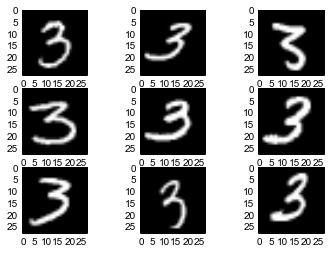

In [10]:
# plot samples from MNIST
mnist = fetch_mldata('MNIST original')
for i in range(9):
    plt.subplot(3, 3, i+1)
    sample = mnist.data[20000+i]
    sample_2d = sample.reshape((28, 28))
    plt.imshow(sample_2d, cmap='gray')

A common task then looks like this:

* Take the first $60000$ samples as training set and the remaining $10000$ samples as test set,
* train a classifier on the training set,
* evaluate the classifier on the test set, i.e., on samples it has never seen before.

Modern approaches are able to classify the unseen samples correctly with an error rate of less than $1\%$.

However, often the algorithms for classification are not applied to the 784-dimensional data directly because they don't work very well in high dimensions. In practice it's often better to project the data into a lower dimensional space first and then solve the (classification) task there.

Intuitively it makes sense that we do not need all $786$ dimensions to solve the problem. For instance we see that neighboring pixels are highly correlated. Also the pixels in the corner are likely to be always black and contain no information about the digits. So, there seem to be a lot of dimensions in the data that are irrelevant or at least highly redundant. That's why we want to project into a sub-space that is less redundant.

Mathematically, projecting a vector into a lower-dimensional sub-space is easy. In the MNIST example we have data vectors $\mathbf{x}_i \in \mathbb{R}^{786}$ with $i = 1, \dots, 70000$. Consider the direction of projection to be given by a vector $\mathbf{u} \in \mathbb{R}^{786}$ with length $||\mathbf{u}|| = 1$. Remember from school that a vector $\mathbf{x}_i$ can be projected onto $\mathbf{u}$ simply through a scalar product, that is: $y_i = \mathbf{u}^T \mathbf{x}_i$. Analogously, if we have have two directions for projection $\mathbf{u}_1$ and $\mathbf{u}_2$, data points can be projected through a matrix $\mathbf{U} = (\mathbf{u}_1, \mathbf{u}_2)$:

$\mathbf{y}_i = \mathbf{U}^T \mathbf{x}_i = (\substack{\mathbf{u}_1^T \\ \mathbf{u}_2^T}) \mathbf{x}_i$

with $\mathbf{x}_i \in \mathbb{R}^{786}$, $\mathbf{U} \in \mathbb{R}^{786 \times 2}$ and $\mathbf{y}_i \in \mathbb{R}^2$.

## Principal Component Analysis (PCA)

But how do we select the directions $\mathbf{u}_1, \mathbf{u}_2, \dots$ for projection given a data set? Without going to much into detail here, PCA selects the directions that have the **smallest (linear) re-construction error**, which is a reasonable objective in many cases. These directions of smallest re-construction error also happen to be the directions of **highest variance** in the data. If you think about it, this makes sense for the MNIST data for instance because all the black pixels in the corner have a very low variance and are thus discarded during the projection.

In the picture you see an example of many two-dimensional data points. The arrows indicate the direction of highest and second highest variance (lowest and second lowest re-construction error, respectively):

![PCA](https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcSKbJODJgBbOUMLbGxtPT-8_9MM_MPMUQ_b1aTrWgBYCCum1q_kJA)

Admitedly, this is a very brief introduction to PCA. I recommend watching the videos of the [Udacity Machine Learning Course](https://www.udacity.com/course/machine-learning--ud262) about PCA as well (and if you want to read a nice explanation of the math of PCA, take a look at the [PCA lecture](http://www.ini.rub.de/uploads/document/attachment/342/LectureNotes-PCA.pdf) of Prof. Wiskott):

[![Principal Component Analysis](http://img.youtube.com/vi/kw9R0nD69OU/0.jpg)](http://www.youtube.com/watch?v=kw9R0nD69OU "Principal Component Analysis")

So how do we find these directions of highest variance? It turns out that these directions are given by the "largest" eigenvectors of the covariance matrix of the data. The proof for this is not very difficult but we skip it here. Let's do it for MNIST!

In [11]:
X = mnist.data
C = np.cov(X, rowvar=0) # slow! may take a while because the data set is large
print 'X.shape:', X.shape
print 'C.shape:', C.shape

X.shape: (70000, 784)
C.shape: (784, 784)


> **Note** that data matrices in Python are often constructed such that the single data vectors are stored in rows (like above). This is exactly the other way round where as you would expect from the mathematical notation, where vectors often are notated as columns. But it has other advantages like the possibility of accessing the single data vectors by `X[i]` instead of `X[i,:]`. So that's the convention we are using in the following.

**Question:** What is this `rowvar` parameter good for? To find out, we can access the documentation from the console by calling `np.cov?`.

In [1]:
np.cov?

Object `np.cov` not found.


Calculate eigenvalues and eigenvectors of covariance matrix $C$ and project data on it:

In [12]:
E, U = np.linalg.eigh(C) # Eigenvalues and eigenvectors of C

As the documentation tells us (call `np.linalg.eigh?`), the resulting eigenvalues and eigenvectors are not necessarily ordered. But there is a useful function to order them: `np.argsort`

In [16]:
idc = np.argsort(E)
print idc[:10]    # first ten indices that would sort the eigenvalues (in increasing order)
print E[idc][:10] # first ten sorted eigenvalues

[0 1 2 3 4 5 6 7 8 9]
[ -2.26573315e-10  -1.75762206e-10  -1.59991309e-10  -1.18134367e-10
  -1.14100991e-10  -7.09340601e-11  -6.25416576e-11  -6.06473491e-11
  -3.72607141e-11  -3.01216671e-11]


> **Note** that `E[idc]` uses a concept called *advanced indexing*, i.e., accessing elements in an array through a list of indices. For more details see the [official documentation](http://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#advanced-indexing).

In [14]:
# sort eigenvalues and eigenvectors
E = E[idc]
U = U[:,idc] # sort columns

In [15]:
U = U[:,-2:] # consider the last two ("largest") eigenvectors
Y = np.dot(mnist.data, U) # project data on these eigenvectors
print Y.shape

(70000, 2)


Now plot each class in the two-dimensional feature space:

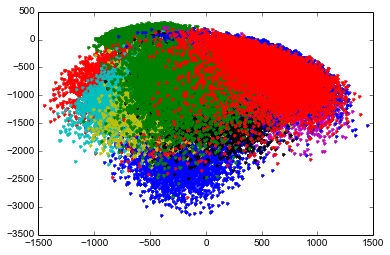

In [17]:
for i in range(10):
    mask = (mnist.target == i)
    class_i = Y[mask,:]
    plt.plot(class_i[:,0], class_i[:,1], '.')

Indeed, quite a lot of information of the data set was preserved in the sense that the different classes can still be distinguished to some degree with only two dimensions (instead of $786$). As you may expect, classes become even more distinguishable when you add some more feature dimensions.

## Eigenfaces

One of the early approaches to face classification was based exactly on such PCA features calculated on face data sets. Let's try this as an exercise!

In [20]:
import sklearn.datasets
download = sklearn.datasets.fetch_olivetti_faces()
faces = download['data']
print faces.shape

(400, 4096)


Now we have an NumPy array of $400$ faces, $64 \times 64 = 4096$ pixels each. Visualize the first 18 images!

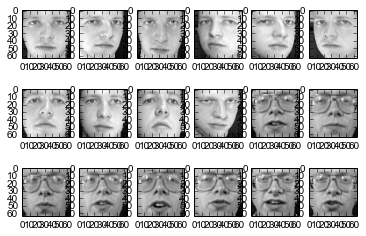

In [21]:
for i in range(18):
    # your code here

As with the MNIST data set, calculating the covariance can take a few minutes. We therfore suggest to do this calculation in a seperate block.

In [1]:
# calculate covariance for faces
# your code here

The again, the eigenvectors must be calculated and sorted...

In [2]:
# calculate eigenvectors of face covariance and sort them
# your code here

With the result we do something a bit more different than above. This time we want to visualize the eigenvectors themselves. Note that each eigenvector $\textbf{u}_i$ is a vector of $64 \times 64 = 4096$ dimensions, each component corresponding to one pixel in the image space. Thus, we can re-arrange each eigenvector to a $64 \times 64$ 2D-NumPy-array and visualize with `np.imshow` as if it was an image. The result makes clear why the approach was called Eigenfaces. It should look somewhat like this:

![Example of Eigenfaces](https://upload.wikimedia.org/wikipedia/commons/6/67/Eigenfaces.png)

Try this with the eigenvectors that you have just calculated!

In [3]:
# plot the 9 "largest" eigenvectors/eigenfaces
for i in range(9):
    # your code here

IndentationError: expected an indented block (<ipython-input-3-f40fa964444c>, line 3)

Now these eigenfaces model how much variance there is in the pixels relative to the mean value. By calculating the mean face and then adding or substracting the eigenfaces we can reconstruct proper faces and even visualize the *meaning* that the different components have.

So, calculate and visualize the average face from the data set first!

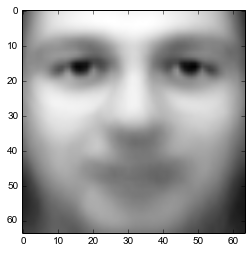

In [27]:
# your code here

Next we visualize how the faces vary in different directions. Take the mean face and visualize how it looks like when the first eigenface is added/substracted to it. Do the same for some more eigenfaces...

> **Note**: Eigenvectors are usually normalized to length one. To make them proportional to the variance that they are describing, we must multiply them with their corresponding eigenvalue first.

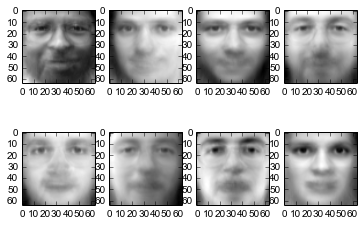

In [28]:
# your code here

Can you guess from the visualizations what *meaning* the eigenvectors might have? Or in other words: Which underlying factors produced the most variance in the faces?